In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

df_path = '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/feature_basic.csv'
df = pd.read_csv(df_path, parse_dates=['fecha'], index_col='fecha')

colum_data_leak = [col for col in df.columns if 'rolling' in col]
df[colum_data_leak] = df[colum_data_leak].shift(1)
df.dropna(inplace=True)

df['target_up'] = (df['returns'] > 0).astype(int)

features = []

for c in df.columns:
    if c not in  ['returns', 'target_up', 'valor']:
        features.append(c)

total_rows = len(df)
train_idx = int(total_rows * 0.70)
val_idx = int(total_rows * 0.85)

x = df[features]
y = df['target_up']

x_train = x.iloc[:train_idx]
y_train = y.iloc[:train_idx]

x_val = x.iloc[train_idx:val_idx]
y_val = y.iloc[train_idx: val_idx]

x_test = x.iloc[val_idx:]
y_test = y.iloc[val_idx:]


""" 
    Debemos normalizar los retornos ya que los datos tienen escalas distintas:
        - El retorno es un número chiquito (ej. 0.01).
        - La volatilidad puede ser otro número diferente.
    La Regresión Logística se confunde si mezclas números grandes con chicos. El StandardScaler pone todo en la misma escala para que el modelo aprenda bien.
"""


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

model = LogisticRegression(random_state=42)
model.fit(x_train_scaled, y_train)

predict = model.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predict)

print("\nResultados del Gran Desafío:")
print(f"Modelo con Features Avanzados: {accuracy:.2%}")
print(f"Baseline a vencer (Como Ayer): 58.68%")

if accuracy > 0.5868:
    print("¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.")
else:
    print("Seguimos empatados o perdiendo. Necesitamos modelos más complejos.")


Resultados del Gran Desafío:
Modelo con Features Avanzados: 52.34%
Baseline a vencer (Como Ayer): 58.68%
Seguimos empatados o perdiendo. Necesitamos modelos más complejos.


Actualmente el modelo sigue sin superar el baseline de 'como ayer'. Supongo que le faltara mas informacion para poder predecir correctamente el mercado. Mi teoria qes que como a partir del 2023 hubo un cambio presidencial y el dolar fue muy volatil en esas fecha no lo predice correctamente ua que entraria en la ventana del x_test y no del train. Esta hipotesis la voya  confirmar mas adelante cuando realice mas pruebas


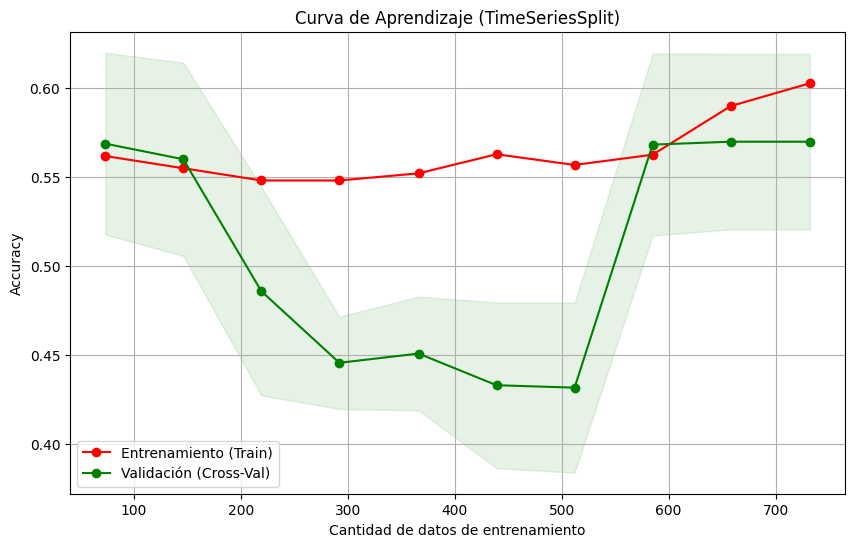

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, TimeSeriesSplit

def plot_learning_curve(estimator, x, y):
    # 1. Definimos la estrategia de validación
    # Divide los datos en 5 ventanas progresivas, respetando el orden.
    cv = TimeSeriesSplit(n_splits=5)

    # 2. Calculamos la curva
    # train_sizes: Cuántos datos usa en cada paso (del 10% al 100%)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, x, y,
        cv=cv,
        scoring='accuracy', # Usamos accuracy porque es tu métrica principal
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # 3. Calculamos promedios y desvíos (para sombrear el gráfico)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # 4. Graficamos
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizaje (TimeSeriesSplit)")
    plt.xlabel("Cantidad de datos de entrenamiento")
    plt.ylabel("Accuracy")

    # Línea de Entrenamiento (Rojo)
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento (Train)")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")

    # Línea de Validación (Verde)
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación (Cross-Val)")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.legend(loc="best")
    plt.grid()
    plt.show()

#el modelo es el de regresion logistica
plot_learning_curve(model, x_train_scaled, y_train)